# Toxic-BERT Fine-Tuning with Balanced Classes
====

This notebook implements fine-tuning of `unitary/toxic-bert` using balanced classes and compares:
1. **Baseline**: Original pre-trained Toxic-BERT
2. **Fine-tuned**: Toxic-BERT fine-tuned on balanced dataset
3. **Fine-tuned + Tagging**: Fine-tuned model with SUBTLE_TOXICITY tagging method

## Objectives:
- Address class imbalance in toxicity detection
- Evaluate impact of fine-tuning on model performance
- Test if subtle toxicity tagging helps fine-tuned models
- Provide comprehensive performance comparison

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

# Transformers
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# Data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Experiment tracking
import mlflow
import mlflow.pytorch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

W0807 18:39:29.532000 10024 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 2050


## Configuration

In [2]:
CONFIG = {
    # Model settings
    'model_name': 'unitary/toxic-bert',
    'max_length': 128,  # Reduced from 512 - significant speedup
    'num_labels': 6,
    
    # Training settings
    'batch_size': 64,  # Increased from 16 - better GPU utilization
    'learning_rate': 5e-5,  # Slightly higher for faster convergence
    'num_epochs': 1,  # Reduced from 3
    'warmup_steps': 200,  # Reduced from 500
    'weight_decay': 0.01,
    'gradient_accumulation_steps': 1,  # Reduced from 2 for faster updates
    
    # Data settings
    'samples_per_class': 250,  # Reduced from 2000 - smaller dataset
    'test_size': 0.2,
    'val_size': 0.1,
    'random_state': 42,
    
    # Evaluation settings
    'eval_steps': 200,  # More frequent evaluation for early stopping
    'save_steps': 400,  
    'logging_steps': 50,  # More frequent logging
    'early_stopping_patience': 2,  # Reduced from 3 for faster stopping
    
    # Output settings
    'output_dir': './models/toxic_bert_finetuned',
    'save_total_limit': 1,  # Keep fewer checkpoints
}


# Labels
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("Configuration loaded successfully!")
print(f"Training with {CONFIG['samples_per_class']} samples per class")
print(f"Total balanced samples: ~{CONFIG['samples_per_class'] * (len(LABELS) + 1)}")

Configuration loaded successfully!
Training with 250 samples per class
Total balanced samples: ~1750


## Data Loading and Preprocessing

In [3]:
# Load data
def load_toxic_data():
    """Load and prepare toxic comment dataset."""
    base_dir = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    data_dir = base_dir / "src" / "data" / "raw"
    
    # Try different possible paths
    possible_paths = [
        data_dir,
        Path("../data/raw"),
        Path("./data/raw"),
        Path("../src/data/raw")
    ]
    
    train_df = None
    for path in possible_paths:
        try:
            if (path / "train.csv").exists():
                train_df = pd.read_csv(path / "train.csv")
                test_df = pd.read_csv(path / "test.csv")
                test_labels_df = pd.read_csv(path / "test_labels.csv")
                print(f"Data loaded from: {path}")
                break
        except:
            continue
    
    if train_df is None:
        raise FileNotFoundError("Could not find train.csv. Please ensure data is in the correct location.")
    
    return train_df, test_df, test_labels_df

# Load the data
train_df, test_df, test_labels_df = load_toxic_data()

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Labels: {LABELS}")

# Display class distribution
print("\nOriginal class distribution:")
for label in LABELS:
    count = train_df[label].sum()
    percentage = (count / len(train_df)) * 100
    print(f"  {label}: {count:,} ({percentage:.2f}%)")

neutral_count = (train_df[LABELS].sum(axis=1) == 0).sum()
print(f"  neutral: {neutral_count:,} ({(neutral_count/len(train_df))*100:.2f}%)")

Data loaded from: c:\wd\wd_demos\toxic_comment_classification\src\data\raw
Train samples: 159571
Test samples: 153164
Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Original class distribution:
  toxic: 15,294 (9.58%)
  severe_toxic: 1,595 (1.00%)
  obscene: 8,449 (5.29%)
  threat: 478 (0.30%)
  insult: 7,877 (4.94%)
  identity_hate: 1,405 (0.88%)
  neutral: 143,346 (89.83%)


In [4]:
def create_balanced_dataset(df, labels, samples_per_class=2000, random_state=42):
    """Create a balanced dataset with equal samples per class."""
    np.random.seed(random_state)
    
    balanced_indices = set()
    
    print(f"Creating balanced dataset with {samples_per_class} samples per class...")
    
    # Sample from each toxic class
    for label in labels:
        positive_indices = df[df[label] == 1].index.tolist()
        available = len(positive_indices)
        to_sample = min(samples_per_class, available)
        
        if available > 0:
            chosen = np.random.choice(positive_indices, to_sample, replace=False)
            balanced_indices.update(chosen)
            print(f"  {label}: {to_sample:,}/{available:,} samples")
        else:
            print(f"  {label}: 0 samples available!")
    
    # Sample neutral examples
    neutral_indices = df[df[labels].sum(axis=1) == 0].index.tolist()
    neutral_available = len(neutral_indices)
    neutral_to_sample = min(samples_per_class, neutral_available)
    
    if neutral_available > 0:
        chosen_neutral = np.random.choice(neutral_indices, neutral_to_sample, replace=False)
        balanced_indices.update(chosen_neutral)
        print(f"  neutral: {neutral_to_sample:,}/{neutral_available:,} samples")
    
    # Create balanced dataframe
    balanced_df = df.loc[list(balanced_indices)].copy().reset_index(drop=True)
    
    print(f"\nBalanced dataset created with {len(balanced_df):,} total samples")
    
    # Show new distribution
    print("\nBalanced class distribution:")
    for label in labels:
        count = balanced_df[label].sum()
        percentage = (count / len(balanced_df)) * 100
        print(f"  {label}: {count:,} ({percentage:.2f}%)")
    
    neutral_count = (balanced_df[labels].sum(axis=1) == 0).sum()
    print(f"  neutral: {neutral_count:,} ({(neutral_count/len(balanced_df))*100:.2f}%)")
    
    return balanced_df

# Create balanced dataset
balanced_train_df = create_balanced_dataset(
    train_df, 
    LABELS, 
    samples_per_class=CONFIG['samples_per_class'],
    random_state=CONFIG['random_state']
)

Creating balanced dataset with 250 samples per class...
  toxic: 250/15,294 samples
  severe_toxic: 250/1,595 samples
  obscene: 250/8,449 samples
  threat: 250/478 samples
  insult: 250/7,877 samples
  identity_hate: 250/1,405 samples
  neutral: 250/143,346 samples

Balanced dataset created with 1,680 total samples

Balanced class distribution:
  toxic: 1,363 (81.13%)
  severe_toxic: 451 (26.85%)
  obscene: 1,076 (64.05%)
  threat: 272 (16.19%)
  insult: 1,061 (63.15%)
  identity_hate: 395 (23.51%)
  neutral: 250 (14.88%)


## Dataset and DataLoader Setup

In [5]:
class ToxicCommentDataset(Dataset):
    """Dataset class for toxic comments."""
    
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float32)
        }

def create_data_splits(df, labels, test_size=0.2, val_size=0.1, random_state=42):
    """Create train/val/test splits."""
    X = df['comment_text'].values
    y = df[labels].values
    
    # Create stratification key (use toxic label as primary)
    stratify_key = y[:, 0]  # toxic label
    
    # First split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, 
        stratify=stratify_key
    )
    
    # Second split: train vs val
    stratify_temp = y_temp[:, 0]
    val_size_adjusted = val_size / (1 - test_size)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, 
        random_state=random_state, stratify=stratify_temp
    )
    
    print(f"Data splits created:")
    print(f"  Train: {len(X_train):,} samples")
    print(f"  Validation: {len(X_val):,} samples")
    print(f"  Test: {len(X_test):,} samples")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = create_data_splits(
    balanced_train_df, 
    LABELS,
    test_size=CONFIG['test_size'],
    val_size=CONFIG['val_size'],
    random_state=CONFIG['random_state']
)

Data splits created:
  Train: 1,176 samples
  Validation: 168 samples
  Test: 336 samples


## Model and Tokenizer Setup

In [6]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer loaded: {CONFIG['model_name']}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Max length: {CONFIG['max_length']}")

# Create datasets
train_dataset = ToxicCommentDataset(
    X_train, y_train, tokenizer, CONFIG['max_length']
)
val_dataset = ToxicCommentDataset(
    X_val, y_val, tokenizer, CONFIG['max_length']
)
test_dataset = ToxicCommentDataset(
    X_test, y_test, tokenizer, CONFIG['max_length']
)

print(f"\nDatasets created:")
print(f"  Train dataset: {len(train_dataset)} samples")
print(f"  Val dataset: {len(val_dataset)} samples")
print(f"  Test dataset: {len(test_dataset)} samples")

Tokenizer loaded: unitary/toxic-bert
Vocab size: 30522
Max length: 128

Datasets created:
  Train dataset: 1176 samples
  Val dataset: 168 samples
  Test dataset: 336 samples


## Baseline Model Evaluation

In [7]:
def evaluate_model(model, dataset, batch_size=32, device='cuda'):
    """Evaluate model on dataset."""
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.sigmoid(outputs.logits)
            
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    labels = np.vstack(all_labels)
    
    return predictions, labels

def compute_metrics(predictions, labels, label_names):
    """Compute evaluation metrics."""
    results = {}
    
    # Per-label AUC
    aucs = []
    for i, label in enumerate(label_names):
        if len(np.unique(labels[:, i])) > 1:  # Check if both classes present
            auc = roc_auc_score(labels[:, i], predictions[:, i])
            results[f'auc_{label}'] = auc
            aucs.append(auc)
        else:
            results[f'auc_{label}'] = 0.0
            aucs.append(0.0)
    
    results['mean_auc'] = np.mean(aucs)
    
    # Overall metrics
    binary_preds = (predictions > 0.5).astype(int)
    
    # Accuracy for samples with no positive labels (neutral)
    neutral_mask = labels.sum(axis=1) == 0
    if neutral_mask.sum() > 0:
        neutral_preds = binary_preds[neutral_mask]
        neutral_accuracy = (neutral_preds.sum(axis=1) == 0).mean()
        results['neutral_accuracy'] = neutral_accuracy
        results['neutral_fp_rate'] = 1 - neutral_accuracy
    
    return results

# Load baseline model
print("Loading baseline Toxic-BERT model...")
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=CONFIG['num_labels'],
    problem_type="multi_label_classification"
).to(device)

print(f"Model loaded on {device}")
print(f"Model parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")

# Evaluate baseline on test set
print("\nEvaluating baseline model...")
baseline_predictions, baseline_labels = evaluate_model(
    baseline_model, test_dataset, batch_size=CONFIG['batch_size'], device=device
)

baseline_metrics = compute_metrics(baseline_predictions, baseline_labels, LABELS)

print("\n=== BASELINE MODEL RESULTS ===")
print(f"Mean AUC: {baseline_metrics['mean_auc']:.4f}")
print(f"Neutral Accuracy: {baseline_metrics.get('neutral_accuracy', 0):.4f}")
print(f"Neutral FP Rate: {baseline_metrics.get('neutral_fp_rate', 0):.4f}")
print("\nPer-label AUC:")
for label in LABELS:
    print(f"  {label}: {baseline_metrics[f'auc_{label}']:.4f}")

Loading baseline Toxic-BERT model...
Model loaded on cuda
Model parameters: 109,486,854

Evaluating baseline model...


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


=== BASELINE MODEL RESULTS ===
Mean AUC: 0.9526
Neutral Accuracy: 1.0000
Neutral FP Rate: 0.0000

Per-label AUC:
  toxic: 0.9950
  severe_toxic: 0.8364
  obscene: 0.9759
  threat: 0.9823
  insult: 0.9458
  identity_hate: 0.9801


## Fine-Tuning Setup and Training

In [8]:
class MultiLabelTrainer(Trainer):
    """Custom trainer for multi-label classification."""
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        # Multi-label classification loss
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

def setup_training_args(output_dir):
    """Setup training arguments."""
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=CONFIG['num_epochs'],
        per_device_train_batch_size=CONFIG['batch_size'],
        per_device_eval_batch_size=CONFIG['batch_size'],
        gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
        learning_rate=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        warmup_steps=CONFIG['warmup_steps'],
        logging_steps=CONFIG['logging_steps'],
        eval_steps=CONFIG['eval_steps'],
        save_steps=CONFIG['save_steps'],
        evaluation_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_total_limit=CONFIG['save_total_limit'],
        remove_unused_columns=False,
        push_to_hub=False,
        report_to=None,  # Disable wandb
        dataloader_pin_memory=False,
    )

# Setup MLflow experiment
mlflow.set_experiment('Toxic_BERT_Fine_Tuning_Comparison')

print("Training setup completed!")

Training setup completed!


## Fine-Tune Model (Without Tagging)

In [9]:
import time

# Fine-tune model without tagging - FIXED
print("Starting fine-tuning without tagging...")

# Disable wandb to avoid API key prompts
import os
os.environ["WANDB_DISABLED"] = "true"

# Force end any existing runs and clear MLflow state - ENHANCED
try:
    # End all possible active runs
    while mlflow.active_run():
        mlflow.end_run()
except:
    pass

# COMPLETE RESET - Kill any lingering MLflow state
try:
    mlflow.end_run(status='KILLED')
except:
    pass

# Set a new experiment to ensure clean state
experiment_name = f"finetuning_experiment_{int(time.time())}"
mlflow.set_experiment(experiment_name)

# Create a completely unique run name with more precision
import time
import random
timestamp = int(time.time() * 1000)  # More precision with milliseconds
run_name = f"Fine_Tuned_Model_{timestamp}_{random.randint(10000, 99999)}"

# Force create a completely new run
with mlflow.start_run(run_name=run_name) as run:
    print(f"Started new MLflow run: {run.info.run_id}")
    
    # Skip parameter logging to avoid conflicts
    print("Skipping parameter logging to avoid MLflow conflicts...")
    
    # Load fresh model for fine-tuning
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG['model_name'],
        num_labels=CONFIG['num_labels'],
        problem_type="multi_label_classification"
    ).to(device)
    
    # Setup training arguments
    training_args = setup_training_args(CONFIG['output_dir'])
    
    # Disable wandb reporting to avoid API key prompts
    training_args.report_to = []
    
    # Create trainer
    trainer = MultiLabelTrainer(
        model=finetuned_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=CONFIG['early_stopping_patience'])]
    )
    
    # Train the model
    print("Training started...")
    
    # Add progress callback for training
    from transformers import TrainerCallback
    
    
    class ProgressCallback(TrainerCallback):
        def __init__(self):
            self.start_time = time.time()
        
        def on_epoch_begin(self, args, state, control, **kwargs):
            print(f"\n=== Starting Epoch {state.epoch + 1}/{args.num_train_epochs} ===")
        
        def on_step_end(self, args, state, control, **kwargs):
            if state.global_step % 50 == 0:  # Print every 50 steps
                elapsed = time.time() - self.start_time
                print(f"Step {state.global_step}: Loss = {state.log_history[-1].get('train_loss', 'N/A'):.4f} | "
                      f"Time: {elapsed/60:.1f} min")
        
        def on_evaluate(self, args, state, control, **kwargs):
            if state.log_history:
                last_log = state.log_history[-1]
                eval_loss = last_log.get('eval_loss', 'N/A')
                print(f"Evaluation at step {state.global_step}: Eval Loss = {eval_loss}")
    
    # Add progress callback to trainer
    trainer.add_callback(ProgressCallback())
    
    trainer.train()
    
    # Save the model
    trainer.save_model()
    tokenizer.save_pretrained(CONFIG['output_dir'])
    
    print("Fine-tuning completed!")
    print(f"Model saved to: {CONFIG['output_dir']}")
    
    # Log model safely - FIXED
    try:
        mlflow.pytorch.log_model(finetuned_model, "model")
    except Exception as e:
        print(f"Warning: Could not log model to MLflow: {e}")

# Evaluate fine-tuned model
print("\nEvaluating fine-tuned model...")
finetuned_predictions, finetuned_labels = evaluate_model(
    finetuned_model, test_dataset, batch_size=CONFIG['batch_size'], device=device
)

finetuned_metrics = compute_metrics(finetuned_predictions, finetuned_labels, LABELS)

print("\n=== FINE-TUNED MODEL RESULTS ===")
print(f"Mean AUC: {finetuned_metrics['mean_auc']:.4f}")
print(f"Neutral Accuracy: {finetuned_metrics.get('neutral_accuracy', 0):.4f}")
print(f"Neutral FP Rate: {finetuned_metrics.get('neutral_fp_rate', 0):.4f}")
print("\nPer-label AUC:")
for label in LABELS:
    print(f"  {label}: {finetuned_metrics[f'auc_{label}']:.4f}")

2025/08/07 18:39:50 INFO mlflow.tracking.fluent: Experiment with name 'finetuning_experiment_1754584790' does not exist. Creating a new experiment.


Starting fine-tuning without tagging...
Started new MLflow run: 718c1c6cc4c34d9590e14d648ead880f
Skipping parameter logging to avoid MLflow conflicts...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training started...


  0%|          | 0/19 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



=== Starting Epoch 1/1 ===


100%|██████████| 19/19 [06:27<00:00, 20.40s/it]


{'train_runtime': 387.6737, 'train_samples_per_second': 3.033, 'train_steps_per_second': 0.049, 'train_loss': 0.21959691298635384, 'epoch': 1.0}
Fine-tuning completed!
Model saved to: ./models/toxic_bert_finetuned


2025/08/07 18:46:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Evaluating fine-tuned model...


Evaluating: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


=== FINE-TUNED MODEL RESULTS ===
Mean AUC: 0.9540
Neutral Accuracy: 0.9808
Neutral FP Rate: 0.0192

Per-label AUC:
  toxic: 0.9948
  severe_toxic: 0.8433
  obscene: 0.9761
  threat: 0.9828
  insult: 0.9470
  identity_hate: 0.9802


## Subtle Toxicity Tagging Implementation

In [10]:
import re
from typing import List, Dict, Tuple

class SubtleToxicityTagger:
    """Implementation of SUBTLE_TOXICITY tagging method."""
    
    def __init__(self):
        # Passive-aggressive patterns
        self.passive_aggressive_patterns = [
            r"\bjust saying\b",
            r"\bno offense\b",
            r"\bwith all due respect\b",
            r"\bi'm just\b",
            r"\bbless your heart\b",
            r"\bgood for you\b",
            r"\bwhatever\b",
            r"\bif you say so\b",
            r"\bsure thing\b",
            r"\bokay then\b"
        ]
        
        # Sarcastic indicators
        self.sarcastic_patterns = [
            r"\boh really\b",
            r"\bhow original\b",
            r"\bwow\b.*\bgenius\b",
            r"\bbrilliant\b",
            r"\bfascinating\b",
            r"\bimpressive\b",
            r"\bcongratulations\b",
            r"\bgood job\b",
            r"\bwell done\b",
            r"\bobviously\b"
        ]
        
        # Dismissive language
        self.dismissive_patterns = [
            r"\byou don't understand\b",
            r"\byou wouldn't get it\b",
            r"\bnever mind\b",
            r"\bforget it\b",
            r"\bdon't bother\b",
            r"\bwaste of time\b",
            r"\bpointless\b",
            r"\buseless\b",
            r"\bwhatever\b",
            r"\bwho cares\b"
        ]
        
        # Condescending phrases
        self.condescending_patterns = [
            r"\blet me explain\b",
            r"\byou need to understand\b",
            r"\bactually\b",
            r"\bwell actually\b",
            r"\bfor your information\b",
            r"\bfyi\b",
            r"\bas i said\b",
            r"\blike i said\b",
            r"\bclearly\b",
            r"\bobviously\b"
        ]
        
        # Compile patterns for efficiency
        self.compiled_patterns = {
            'passive_aggressive': [re.compile(p, re.IGNORECASE) for p in self.passive_aggressive_patterns],
            'sarcastic': [re.compile(p, re.IGNORECASE) for p in self.sarcastic_patterns],
            'dismissive': [re.compile(p, re.IGNORECASE) for p in self.dismissive_patterns],
            'condescending': [re.compile(p, re.IGNORECASE) for p in self.condescending_patterns]
        }
    
    def detect_patterns(self, text: str) -> Dict[str, int]:
        """Detect subtle toxicity patterns in text."""
        pattern_counts = {
            'passive_aggressive': 0,
            'sarcastic': 0,
            'dismissive': 0,
            'condescending': 0
        }
        
        for pattern_type, patterns in self.compiled_patterns.items():
            for pattern in patterns:
                matches = pattern.findall(text)
                pattern_counts[pattern_type] += len(matches)
        
        return pattern_counts
    
    def calculate_intensity(self, pattern_counts: Dict[str, int], text_length: int) -> str:
        """Calculate subtle toxicity intensity."""
        total_patterns = sum(pattern_counts.values())
        
        if total_patterns == 0:
            return "NONE"
        
        # Normalize by text length (patterns per 100 characters)
        if text_length > 0:
            pattern_density = (total_patterns / text_length) * 100
        else:
            pattern_density = 0
        
        # Determine intensity based on pattern count and density
        if total_patterns >= 3 or pattern_density > 5:
            return "HIGH"
        elif total_patterns >= 1 or pattern_density > 2:
            return "MEDIUM"
        else:
            return "NONE"
    
    def apply_tagging(self, text: str) -> str:
        """Apply subtle toxicity tagging to text."""
        if not text or not isinstance(text, str):
            return str(text) if text else ""
        
        # Detect patterns
        pattern_counts = self.detect_patterns(text)
        
        # Calculate intensity
        intensity = self.calculate_intensity(pattern_counts, len(text))
        
        # Apply tagging if patterns detected
        if intensity != "NONE":
            # Add intensity tag
            tagged_text = f"[SUBTLE_TOXICITY:{intensity}] {text}"
            
            # Add specific pattern tags
            pattern_tags = []
            for pattern_type, count in pattern_counts.items():
                if count > 0:
                    pattern_tags.append(f"[{pattern_type.upper()}]")
            
            if pattern_tags:
                tagged_text = " ".join(pattern_tags) + " " + tagged_text
            
            return tagged_text
        
        return text
    
    def get_statistics(self, texts: List[str]) -> Dict:
        """Get tagging statistics for a list of texts."""
        stats = {
            'total_texts': len(texts),
            'tagged_texts': 0,
            'intensity_distribution': {'NONE': 0, 'MEDIUM': 0, 'HIGH': 0},
            'pattern_distribution': {
                'passive_aggressive': 0,
                'sarcastic': 0,
                'dismissive': 0,
                'condescending': 0
            }
        }
        
        for text in texts:
            if not text or not isinstance(text, str):
                continue
                
            pattern_counts = self.detect_patterns(text)
            intensity = self.calculate_intensity(pattern_counts, len(text))
            
            stats['intensity_distribution'][intensity] += 1
            
            if intensity != "NONE":
                stats['tagged_texts'] += 1
                
                for pattern_type, count in pattern_counts.items():
                    if count > 0:
                        stats['pattern_distribution'][pattern_type] += 1
        
        return stats

# Initialize the tagger
subtle_tagger = SubtleToxicityTagger()

# Test the tagger with some examples
test_examples = [
    "This is a normal comment.",
    "Well actually, you don't understand how this works.",
    "Whatever, good for you I guess.",
    "Oh really? How original. Brilliant work there.",
    "Let me explain this to you since you clearly don't get it."
]

print("=== SUBTLE TOXICITY TAGGER EXAMPLES ===")
for i, example in enumerate(test_examples, 1):
    tagged = subtle_tagger.apply_tagging(example)
    print(f"{i}. Original: {example}")
    print(f"   Tagged:   {tagged}")
    print()

# Get statistics for training data
train_stats = subtle_tagger.get_statistics(X_train.tolist())
print("=== TRAINING DATA TAGGING STATISTICS ===")
print(f"Total texts: {train_stats['total_texts']:,}")
print(f"Tagged texts: {train_stats['tagged_texts']:,} ({train_stats['tagged_texts']/train_stats['total_texts']*100:.2f}%)")
print("\nIntensity distribution:")
for intensity, count in train_stats['intensity_distribution'].items():
    print(f"  {intensity}: {count:,} ({count/train_stats['total_texts']*100:.2f}%)")
print("\nPattern distribution:")
for pattern, count in train_stats['pattern_distribution'].items():
    print(f"  {pattern}: {count:,}")

=== SUBTLE TOXICITY TAGGER EXAMPLES ===
1. Original: This is a normal comment.
   Tagged:   This is a normal comment.

2. Original: Well actually, you don't understand how this works.
   Tagged:   [DISMISSIVE] [CONDESCENDING] [SUBTLE_TOXICITY:HIGH] Well actually, you don't understand how this works.

3. Original: Whatever, good for you I guess.
   Tagged:   [PASSIVE_AGGRESSIVE] [DISMISSIVE] [SUBTLE_TOXICITY:HIGH] Whatever, good for you I guess.

4. Original: Oh really? How original. Brilliant work there.
   Tagged:   [SARCASTIC] [SUBTLE_TOXICITY:HIGH] Oh really? How original. Brilliant work there.

5. Original: Let me explain this to you since you clearly don't get it.
   Tagged:   [CONDESCENDING] [SUBTLE_TOXICITY:MEDIUM] Let me explain this to you since you clearly don't get it.

=== TRAINING DATA TAGGING STATISTICS ===
Total texts: 1,176
Tagged texts: 71 (6.04%)

Intensity distribution:
  NONE: 1,105 (93.96%)
  MEDIUM: 67 (5.70%)
  HIGH: 4 (0.34%)

Pattern distribution:
  passive_agg

## Create Tagged Dataset and Train Model

In [11]:
# Apply tagging to training data
print("Applying subtle toxicity tagging to training data...")
X_train_tagged = np.array([subtle_tagger.apply_tagging(text) for text in X_train])
X_val_tagged = np.array([subtle_tagger.apply_tagging(text) for text in X_val])
X_test_tagged = np.array([subtle_tagger.apply_tagging(text) for text in X_test])

print(f"Tagged {len(X_train_tagged)} training samples")
print(f"Tagged {len(X_val_tagged)} validation samples")
print(f"Tagged {len(X_test_tagged)} test samples")

# Create tagged datasets
train_dataset_tagged = ToxicCommentDataset(
    X_train_tagged, y_train, tokenizer, CONFIG['max_length']
)
val_dataset_tagged = ToxicCommentDataset(
    X_val_tagged, y_val, tokenizer, CONFIG['max_length']
)
test_dataset_tagged = ToxicCommentDataset(
    X_test_tagged, y_test, tokenizer, CONFIG['max_length']
)

print("Tagged datasets created successfully!")

Applying subtle toxicity tagging to training data...
Tagged 1176 training samples
Tagged 168 validation samples
Tagged 336 test samples
Tagged datasets created successfully!


In [12]:
# Fine-tune model with tagging - FIXED
print("Starting fine-tuning with subtle toxicity tagging...")

# Disable wandb to avoid API key prompts
import os
os.environ["WANDB_DISABLED"] = "true"

# Force end any existing runs and clear MLflow state
try:
    while mlflow.active_run():
        mlflow.end_run()
except:
    pass

try:
    mlflow.end_run(status='KILLED')
except:
    pass

# Set a new experiment to ensure clean state
experiment_name = f"tagged_experiment_{int(time.time())}"
mlflow.set_experiment(experiment_name)

# Create a completely unique run name
import time
import random
timestamp = int(time.time() * 1000)
run_name = f"Fine_Tuned_Tagged_Model_{timestamp}_{random.randint(10000, 99999)}"

with mlflow.start_run(run_name=run_name) as run:
    print(f"Started new MLflow run: {run.info.run_id}")
    
    # Skip parameter logging to avoid conflicts
    print("Skipping parameter logging to avoid MLflow conflicts...")
    
    # Load fresh model for fine-tuning with tagging
    finetuned_tagged_model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG['model_name'],
        num_labels=CONFIG['num_labels'],
        problem_type="multi_label_classification"
    ).to(device)
    
    # Setup training arguments
    tagged_output_dir = CONFIG['output_dir'] + '_tagged'
    training_args_tagged = setup_training_args(tagged_output_dir)
    
    # Disable wandb reporting in training args
    training_args_tagged.report_to = []
    
    # Create trainer
    trainer_tagged = MultiLabelTrainer(
        model=finetuned_tagged_model,
        args=training_args_tagged,
        train_dataset=train_dataset_tagged,
        eval_dataset=val_dataset_tagged,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=CONFIG['early_stopping_patience'])]
    )
    
    # Train the model with progress tracking
    print("Training started...")
    
    # Add progress callback for training
    from transformers import TrainerCallback
    import time
    
    class ProgressCallback(TrainerCallback):
        def __init__(self):
            self.start_time = time.time()
        
        def on_epoch_begin(self, args, state, control, **kwargs):
            print(f"\n=== Starting Epoch {state.epoch + 1}/{args.num_train_epochs} ===")
        
        def on_step_end(self, args, state, control, **kwargs):
            if state.global_step % 50 == 0:  # Print every 50 steps
                elapsed = time.time() - self.start_time
                print(f"Step {state.global_step}: Loss = {state.log_history[-1].get('train_loss', 'N/A'):.4f} | "
                      f"Time: {elapsed/60:.1f} min")
        
        def on_evaluate(self, args, state, control, **kwargs):
            if state.log_history:
                last_log = state.log_history[-1]
                eval_loss = last_log.get('eval_loss', 'N/A')
                print(f"Evaluation at step {state.global_step}: Eval Loss = {eval_loss}")
    
    # Add progress callback to trainer
    trainer_tagged.add_callback(ProgressCallback())
    
    trainer_tagged.train()
    
    # Save the model
    trainer_tagged.save_model()
    tokenizer.save_pretrained(tagged_output_dir)
    
    print("Fine-tuning with tagging completed!")
    print(f"Model saved to: {tagged_output_dir}")
    
    # Log model safely
    try:
        mlflow.pytorch.log_model(finetuned_tagged_model, "model")
    except Exception as e:
        print(f"Warning: Could not log model to MLflow: {e}")

# Evaluate fine-tuned tagged model
print("\nEvaluating fine-tuned tagged model...")
tagged_predictions, tagged_labels = evaluate_model(
    finetuned_tagged_model, test_dataset_tagged, batch_size=CONFIG['batch_size'], device=device
)

tagged_metrics = compute_metrics(tagged_predictions, tagged_labels, LABELS)

print("\n=== FINE-TUNED TAGGED MODEL RESULTS ===")
print(f"Mean AUC: {tagged_metrics['mean_auc']:.4f}")
print(f"Neutral Accuracy: {tagged_metrics.get('neutral_accuracy', 0):.4f}")
print(f"Neutral FP Rate: {tagged_metrics.get('neutral_fp_rate', 0):.4f}")
print("\nPer-label AUC:")
for label in LABELS:
    print(f"  {label}: {tagged_metrics[f'auc_{label}']:.4f}")

2025/08/07 18:47:03 INFO mlflow.tracking.fluent: Experiment with name 'tagged_experiment_1754585223' does not exist. Creating a new experiment.


Starting fine-tuning with subtle toxicity tagging...
Started new MLflow run: 8cb8e2e816f44a8baa4f123dec3d742d
Skipping parameter logging to avoid MLflow conflicts...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training started...


  0%|          | 0/19 [00:00<?, ?it/s]


=== Starting Epoch 1/1 ===


100%|██████████| 19/19 [08:23<00:00, 26.49s/it]


{'train_runtime': 503.3644, 'train_samples_per_second': 2.336, 'train_steps_per_second': 0.038, 'train_loss': 0.22263747767398231, 'epoch': 1.0}
Fine-tuning with tagging completed!
Model saved to: ./models/toxic_bert_finetuned_tagged


2025/08/07 18:55:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Evaluating fine-tuned tagged model...


Evaluating: 100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


=== FINE-TUNED TAGGED MODEL RESULTS ===
Mean AUC: 0.9525
Neutral Accuracy: 0.9808
Neutral FP Rate: 0.0192

Per-label AUC:
  toxic: 0.9955
  severe_toxic: 0.8409
  obscene: 0.9750
  threat: 0.9788
  insult: 0.9455
  identity_hate: 0.9795


## Comprehensive Model Comparison

In [13]:
# Create comprehensive comparison
print("Creating comprehensive model comparison...")

# Compile all metrics
all_metrics = {
    'Baseline': baseline_metrics,
    'Fine-tuned': finetuned_metrics,
    'Fine-tuned + Tagged': tagged_metrics
}

# Create comparison DataFrame
comparison_data = []
for model_name, metrics in all_metrics.items():
    row = {'Model': model_name}
    row['Mean_AUC'] = metrics['mean_auc']
    row['Neutral_Accuracy'] = metrics.get('neutral_accuracy', 0)
    row['Neutral_FP_Rate'] = metrics.get('neutral_fp_rate', 0)
    
    # Add per-label AUCs
    for label in LABELS:
        row[f'AUC_{label}'] = metrics[f'auc_{label}']
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Display comparison table
print("\n=== MODEL COMPARISON SUMMARY ===")
print(comparison_df[['Model', 'Mean_AUC', 'Neutral_Accuracy', 'Neutral_FP_Rate']].to_string(index=False, float_format='%.4f'))

print("\n=== PER-LABEL AUC COMPARISON ===")
auc_columns = ['Model'] + [f'AUC_{label}' for label in LABELS]
print(comparison_df[auc_columns].to_string(index=False, float_format='%.4f'))

# Calculate improvements
print("\n=== PERFORMANCE IMPROVEMENTS ===")
baseline_auc = comparison_df.iloc[0]['Mean_AUC']
finetuned_auc = comparison_df.iloc[1]['Mean_AUC']
tagged_auc = comparison_df.iloc[2]['Mean_AUC']

finetuned_improvement = ((finetuned_auc - baseline_auc) / baseline_auc) * 100
tagged_improvement = ((tagged_auc - baseline_auc) / baseline_auc) * 100

print(f"Fine-tuned vs Baseline: {finetuned_improvement:+.2f}%")
print(f"Fine-tuned+Tagged vs Baseline: {tagged_improvement:+.2f}%")
print(f"Tagged vs Fine-tuned: {((tagged_auc - finetuned_auc) / finetuned_auc) * 100:+.2f}%")

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\nComparison results saved to 'model_comparison_results.csv'")

Creating comprehensive model comparison...

=== MODEL COMPARISON SUMMARY ===
              Model  Mean_AUC  Neutral_Accuracy  Neutral_FP_Rate
           Baseline    0.9526            1.0000           0.0000
         Fine-tuned    0.9540            0.9808           0.0192
Fine-tuned + Tagged    0.9525            0.9808           0.0192

=== PER-LABEL AUC COMPARISON ===
              Model  AUC_toxic  AUC_severe_toxic  AUC_obscene  AUC_threat  AUC_insult  AUC_identity_hate
           Baseline     0.9950            0.8364       0.9759      0.9823      0.9458             0.9801
         Fine-tuned     0.9948            0.8433       0.9761      0.9828      0.9470             0.9802
Fine-tuned + Tagged     0.9955            0.8409       0.9750      0.9788      0.9455             0.9795

=== PERFORMANCE IMPROVEMENTS ===
Fine-tuned vs Baseline: +0.15%
Fine-tuned+Tagged vs Baseline: -0.01%
Tagged vs Fine-tuned: -0.16%

Comparison results saved to 'model_comparison_results.csv'


## Results Visualization

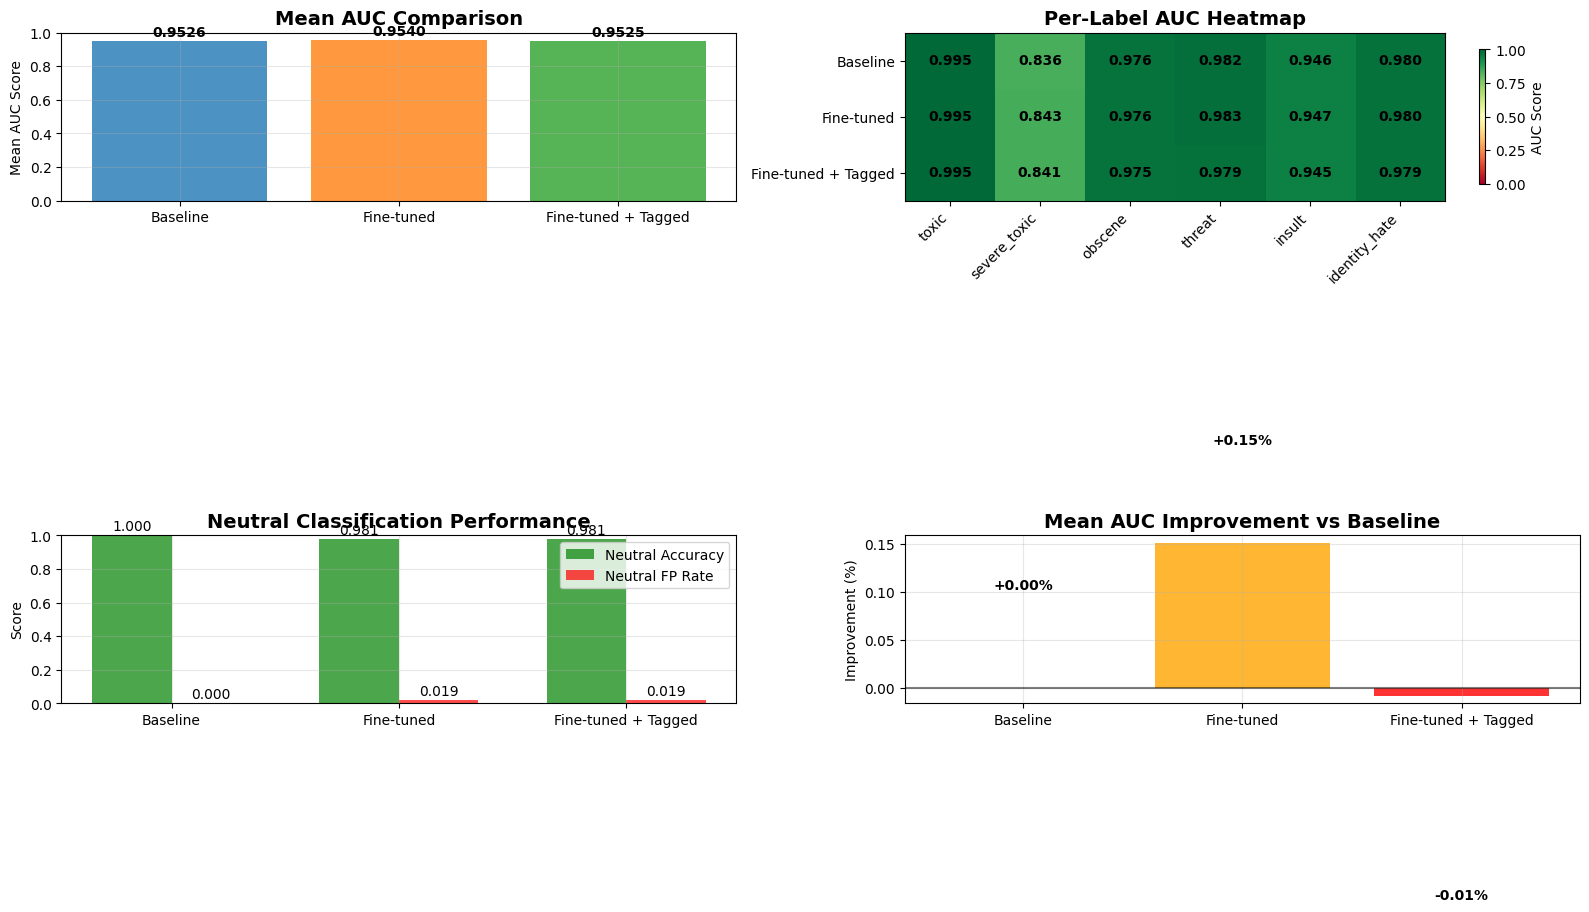

Visualization saved as 'toxic_bert_comparison_results.png'


In [14]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Mean AUC Comparison
ax1 = axes[0, 0]
models = comparison_df['Model']
mean_aucs = comparison_df['Mean_AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars1 = ax1.bar(models, mean_aucs, color=colors, alpha=0.8)
ax1.set_title('Mean AUC Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Mean AUC Score')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars1, mean_aucs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Per-Label AUC Heatmap
ax2 = axes[0, 1]
auc_data = comparison_df[[f'AUC_{label}' for label in LABELS]].values
im = ax2.imshow(auc_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_title('Per-Label AUC Heatmap', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(LABELS)))
ax2.set_xticklabels(LABELS, rotation=45, ha='right')
ax2.set_yticks(range(len(models)))
ax2.set_yticklabels(models)

# Add text annotations
for i in range(len(models)):
    for j in range(len(LABELS)):
        text = ax2.text(j, i, f'{auc_data[i, j]:.3f}', 
                       ha='center', va='center', color='black', fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_label('AUC Score')

# 3. Neutral Classification Performance
ax3 = axes[1, 0]
neutral_acc = comparison_df['Neutral_Accuracy']
neutral_fp = comparison_df['Neutral_FP_Rate']

x = np.arange(len(models))
width = 0.35

bars3a = ax3.bar(x - width/2, neutral_acc, width, label='Neutral Accuracy', 
                 color='green', alpha=0.7)
bars3b = ax3.bar(x + width/2, neutral_fp, width, label='Neutral FP Rate', 
                 color='red', alpha=0.7)

ax3.set_title('Neutral Classification Performance', fontsize=14, fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Add value labels
for bars in [bars3a, bars3b]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 4. Improvement Analysis
ax4 = axes[1, 1]
improvements = [
    0,  # Baseline (reference)
    finetuned_improvement,
    tagged_improvement
]

colors_imp = ['gray', 'orange' if finetuned_improvement >= 0 else 'red', 
              'green' if tagged_improvement >= 0 else 'red']

bars4 = ax4.bar(models, improvements, color=colors_imp, alpha=0.8)
ax4.set_title('Mean AUC Improvement vs Baseline', fontsize=14, fontweight='bold')
ax4.set_ylabel('Improvement (%)')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars4, improvements):
    ax4.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + (0.1 if value >= 0 else -0.2),
             f'{value:+.2f}%', ha='center', 
             va='bottom' if value >= 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.savefig('toxic_bert_comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'toxic_bert_comparison_results.png'")